In [33]:
import numpy as np
from numpy.random import exponential
import matplotlib.pyplot as plt
import matplotlib
from lmfit import Model
from lmfit.models import LinearModel
from pandas import DataFrame, read_csv

In [19]:
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Sample an exponential distribution

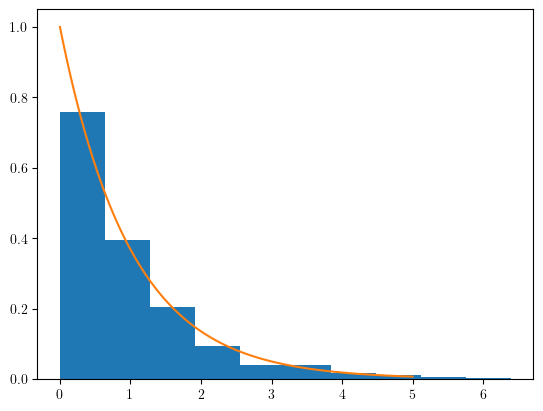

In [20]:
sampled = np.random.rand(1000)
transform_u = lambda u, A: -np.log(u)/A
x = np.linspace(0, 5, 100)

plt.hist(transform_u(sampled, 1), density=True)
plt.plot(x, np.exp(-x))
plt.savefig('../deliverables/figures/exp_dist.pdf')

## Monte-Carlo Simulation

In [21]:
initial_energy = 1e+3
brem_crit = 6.9
radiation_length = 5.80
n_trials = 100

In [26]:
def cascade_trial(
        radiation_length=5.80,
        initial_energy=1e+3, 
        ion_loss_rate=2.,
        brem_crit=6.9,
        m_e=0.511,
        max_particles=1000000
    ):
    photons = np.zeros((max_particles, 3))
    photon_count = 1 # number of photons that have ever been created

    charged = np.zeros((max_particles, 3))
    charged_count = 0 # number of charged particles that have ever been created

    brem_events = 0
    pair_events = 0

    photons[0, 0] = initial_energy
    photons[0, 2] = 1  # active
    # 0: energy, 1: distance, 2: active
    productive_present = lambda phot: np.logical_and(phot[:, 0] > 2*m_e, phot[:, 2] == 1)
    while productive_present(photons).any():
        # photon effects
        productive = productive_present(photons)
        pair_events += len(photons[productive])
        photons[productive, 1] += exponential(size=max_particles, scale=(9/7)*radiation_length)[productive]

        new_pairs = np.zeros(photons[productive].shape)
        new_pairs[:, 0] = photons[productive, 0] / 2
        new_pairs[:, 1] = photons[productive, 1]
        new_pairs[:, 2] = 1
        new_pairs = np.repeat(new_pairs, 2, axis=0)
        charged[charged_count:charged_count+new_pairs.shape[0], :] = new_pairs
        charged_count += new_pairs.shape[0]

        # make the pair-production photons inactive
        photons[productive, 2] = 0

        # charged particle effects
        bremming = charged[:, 0] > brem_crit
        travel = exponential(size=max_particles, scale=radiation_length)[bremming]
        brem_energy = charged[bremming, 0] * (1 - np.exp(-travel / radiation_length))

        charged[bremming, 0] -= brem_energy + ion_loss_rate * travel
        charged[bremming, 1] += travel
        charged[bremming, 2] = 1

        # charged particles that have lost all their energy are made inactive
        spent_particles = charged[:, 0] < 0
        charged[spent_particles, 0] = 0.
        charged[spent_particles, 2] = 0

        brem_photons = np.zeros(charged[bremming].shape)
        brem_photons[:, 0] = brem_energy
        brem_photons[:, 1] = charged[bremming, 1]
        brem_photons[brem_photons[:, 0] > 2 * m_e, 2] = 1

        photons[photon_count:photon_count+brem_photons.shape[0], :] = brem_photons
        photon_count += brem_photons.shape[0]
        brem_events += brem_photons.shape[0]

    return photons, charged, brem_events, pair_events

In [28]:
total_charged = []
total_photons = []
for i in range(n_trials):
    photons, charged, brem_events, pair_events = cascade_trial()
    total_charged.append(charged[charged[:, 1] > 0, :])
    total_photons.append(photons[photons[:, 1] > 0, :])
    
total_charged = np.vstack(total_charged)
total_photons = np.vstack(total_photons)

In [29]:
charged_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
charged_save.to_csv('data/charged_1000.csv', index=False)

photon_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
photon_save.to_csv('data/photon_1000.csv', index=False)

[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 3
    chi-square         = 3.63022328
    reduced chi-square = 0.04972909
    Akaike info crit   = -225.149378
    Bayesian info crit = -218.157178
    R-squared          = 0.99487692
[[Variables]]
    a:  6.3952e-05 +/- 1.5014e-05 (23.48%) (init = 0.008)
    b:  4.06582856 +/- 0.07886042 (1.94%) (init = 4)
    c:  12.2261355 +/- 0.21710408 (1.78%) (init = 13)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9964
    C(b, c) = -0.9728
    C(a, c) = +0.9508


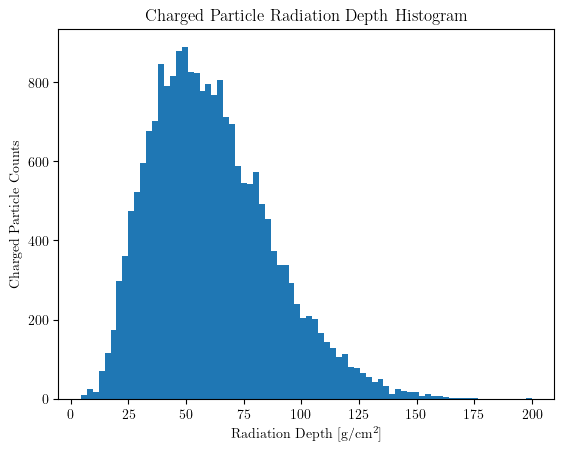

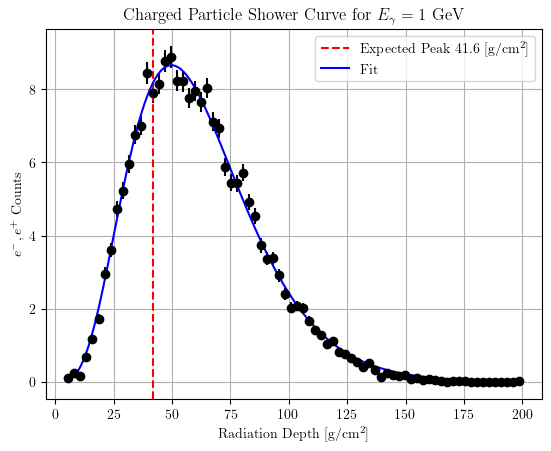

In [30]:
total_charged = read_csv('data/charged.csv')
total_photons = read_csv('data/photon.csv')

bin_counts, bin_edges, _ = plt.hist(total_charged['Depth (g/cm2)'], density=False, bins='auto', label=f'Trials = {n_trials}');
bin_counts /= n_trials
plt.xlabel('Radiation Depth [g/cm$^2$]')
plt.ylabel('Charged Particle Counts')
plt.title('Charged Particle Radiation Depth Histogram')
plt.savefig('../deliverables/figures/charged_depth_hist.pdf')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

def fit_function(x, a, b, c):
    return a * x ** b * np.exp(-x / c)

x = bin_centers
y = bin_counts

fit_model = Model(fit_function)
params = fit_model.make_params(a=8e-3, b=4., c=13)
results = fit_model.fit(y, params, x=x)
x_fit = np.linspace(
    bin_centers.min(),
    bin_centers.max(),
    500
)

fig, ax = plt.subplots()
ax.grid()
# ax.scatter(bin_centers, bin_counts, color='black', label='Data')
ax.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts / n_trials), fmt='o', color='black')
ax.set_xlabel('Radiation Depth [g/cm$^2$]')
ax.set_ylabel('$e^-,e^+$ Counts')
ax.set_title('Charged Particle Shower Curve for $E_\\gamma = 1$ GeV')

expected_peak = np.log(initial_energy / brem_crit) / np.log(2.) * radiation_length
ax.axvline(expected_peak, color='red', linestyle='--', label=f'Expected Peak {expected_peak:.3} [g/cm$^2$]')

ax.plot(x_fit, fit_model.eval(results.params, x=x_fit), label='Fit', color='blue')
ax.legend()

fig.savefig('../deliverables/figures/charged_depth_results.pdf')
print(results.fit_report())

- errorbars of a histogram [Histograms](https://www.quarknet.org/sites/default/files/histogram_uncertainty_tchr_31oct19.pdf):
> When collecting data by counting, the underlying statistical distribution is a Poisson distribution
because counting can never be negative. Since particle physicists perform counting experiments, the
uncertainty in a count is determined using the standard deviation for the Poisson distribution $$\sqrt{N}$$

## Other analyses
- Modeling how fit parameters vary with bin count/width
- Plotting shower curve area to initial photon energy

Text(0.5, 1.0, 'Cascade Spectrum for $E_\\gamma = 1$ GeV')

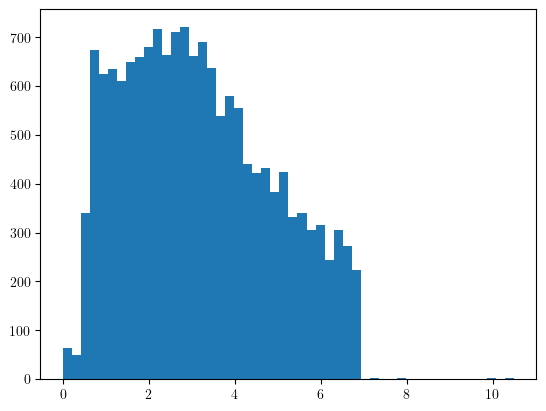

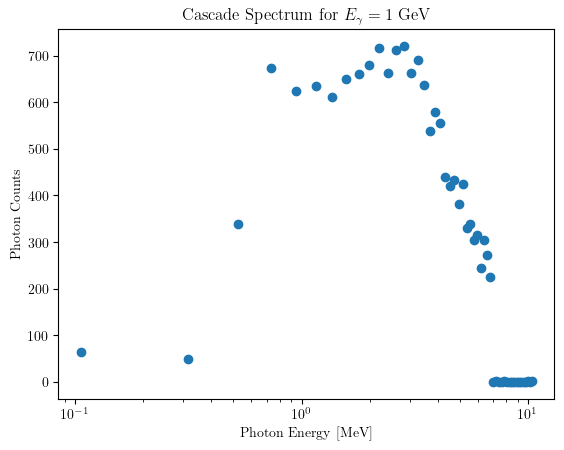

In [7]:
photons = total_photons[total_photons['Energy (MeV)'] > 0]['Energy (MeV)']
energy_counts, energy_bins, _ = plt.hist(photons, density=False, bins='auto');
energy_centers = (energy_bins[1:] + energy_bins[:-1])/2

fig2, ax2 = plt.subplots()
ax2.semilogx(energy_centers, energy_counts, 'o')
ax2.set_xlabel('Photon Energy [MeV]')
ax2.set_ylabel('Photon Counts')
ax2.set_title('Cascade Spectrum for $E_\\gamma = 1$ GeV')

In [31]:
shower_curve_area = np.trapz(bin_counts, bin_centers)
shower_curve_area

540.8374446018418

## Convergence Testing with Bin counts

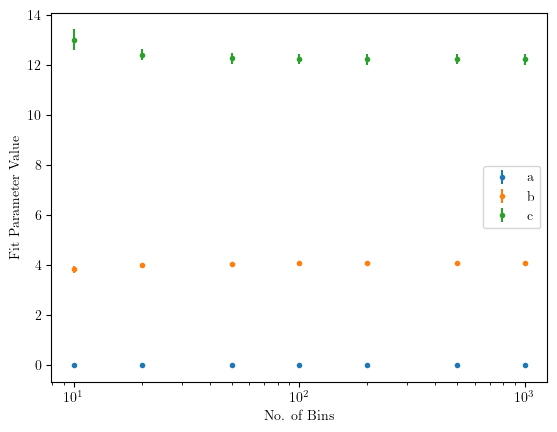

In [16]:
total_charged = read_csv('data/charged.csv')
total_photons = read_csv('data/photon.csv')

def fit_function(x, a, b, c):
    return a * x ** b * np.exp(-x / c)

n_bins = np.array([10, 20, 50, 100, 200, 500, 1000])
a_arr = []
a_err = []
b_arr = []
b_err = []
c_arr = []
c_err = []
for n_bin in n_bins:
    bin_counts, bin_edges = np.histogram(total_charged['Depth (g/cm2)'], bins=n_bin)
    bin_counts = np.divide(bin_counts, n_trials)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2


    x = bin_centers
    y = bin_counts

    fit_model = Model(fit_function)
    params = fit_model.make_params(a=8e-3, b=4., c=13)
    results = fit_model.fit(y, params, x=x)
    a_arr.append(results.params['a'].value)
    a_err.append(results.params['a'].stderr)
    b_arr.append(results.params['b'].value)
    b_err.append(results.params['b'].stderr)
    c_arr.append(results.params['c'].value)
    c_err.append(results.params['c'].stderr)

a_arr = np.array(a_arr)
b_arr = np.array(b_arr)
c_arr = np.array(c_arr)

fig, ax = plt.subplots()
ax.errorbar(n_bins, a_arr, yerr=a_err, fmt='o', label='a', markersize=3)
ax.errorbar(n_bins, b_arr, yerr=b_err, fmt='o', label='b', markersize=3)
ax.errorbar(n_bins, c_arr, yerr=c_err, fmt='o', label='c', markersize=3)
ax.set_xscale('log')
ax.set_xlabel('No. of Bins')
ax.set_ylabel('Fit Parameter Value')
ax.legend()

fig.savefig('../deliverables/figures/fit_parameter_convergence.pdf')

## Plotting initial photon energy and shower curve area

In [30]:
photon_energies = np.logspace(1, 4, 10)
for e in photon_energies:
    total_charged = []
    total_photons = []
    for i in range(n_trials):
        photons, charged, brem_events, pair_events = cascade_trial(initial_energy=e)
        total_charged.append(charged[charged[:, 1] > 0, :])
        total_photons.append(photons[photons[:, 1] > 0, :])
        
    total_charged = np.vstack(total_charged)
    total_photons = np.vstack(total_photons)

    charged_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
    energy_int = str(int(e))
    charged_save.to_csv(f'data/charged_{energy_int}.csv', index=False)

    photon_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
    photon_save.to_csv(f'data/photon_{energy_int}.csv', index=False)

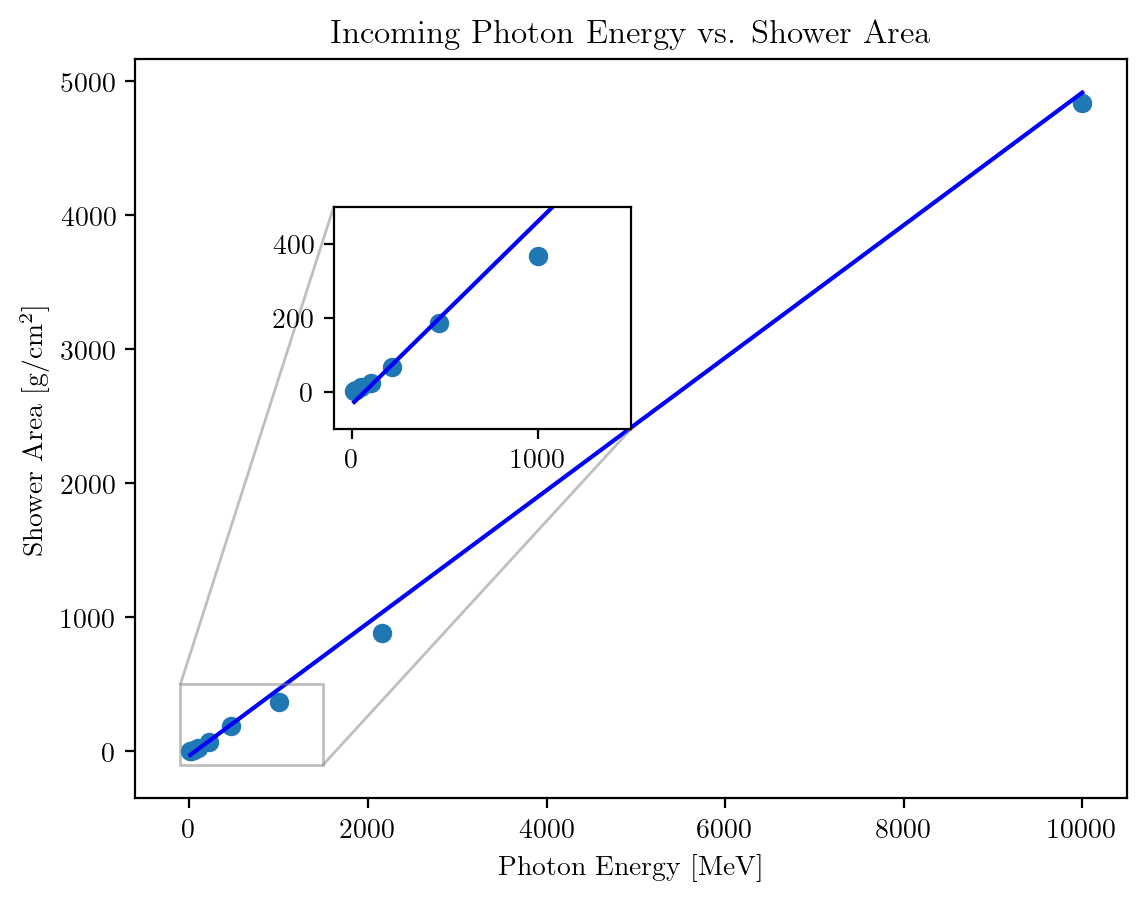

In [65]:
photon_energies = np.logspace(1, 4, 10)
shower_areas = []
for e in photon_energies:
    energy_int = str(int(e))
    total_charged = read_csv(f'data/charged_{energy_int}.csv')
    bin_counts, bin_edges = np.histogram(total_charged['Depth (g/cm2)'], bins=100)
    bin_counts = np.divide(bin_counts, n_trials)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    shower_areas.append(np.trapz(bin_counts, bin_centers))


x = photon_energies
y = shower_areas

inc_model = LinearModel()
params = inc_model.make_params(slope=1, intercept=1)
results = inc_model.fit(y, params, x=x)
x_fit = np.linspace(
    photon_energies.min(),
    photon_energies.max(),
    100
)

fig, ax = plt.subplots(dpi=200)
ax.plot(photon_energies, shower_areas, 'o')
ax.plot(x_fit, inc_model.eval(results.params, x=x_fit), label='Fit', color='blue')

axin = ax.inset_axes([0.2, 0.5, 0.3, 0.3])
axin.set_xlim(-100, 1.5e+3)
axin.set_ylim(-100, 500)
ax.indicate_inset_zoom(axin)
axin.plot(photon_energies, shower_areas, 'o')
axin.plot(x_fit, inc_model.eval(results.params, x=x_fit), label='Fit', color='blue')
ax.set_xlabel('Photon Energy [MeV]')
ax.set_ylabel('Shower Area [g/cm$^2$]')
ax.set_title('Incoming Photon Energy vs. Shower Area')

fig.savefig('../deliverables/figures/shower_area_vs_energy.pdf')

In [69]:
print(results.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 10
    # variables        = 2
    chi-square         = 110753.096
    reduced chi-square = 13844.1371
    Akaike info crit   = 97.1247355
    Bayesian info crit = 97.7299057
    R-squared          = 0.99514144
[[Variables]]
    slope:      0.49477654 +/- 0.01222293 (2.47%) (init = 1)
    intercept: -33.0075890 +/- 43.6378333 (132.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.5225
